# Unit3-1 Stable Diffusion introduction

## Introduction
这本笔记本包括，如何利用现有的管道调用Stable Diffusion来创建和修改图像的基础知识。我们还将简要介绍管道内的关键组件，而把对这些组件的进一步探索留给深入研究的笔记本。具体来说，我们将涵盖：
- 使用 `StableDiffusionPipeline` 生成图像并使用不同的参数进行实验
- 实地考察Pipeline中关键的部件
    - The **VAE** that makes this a 'latent diffusion model'
    - The **tokenizer and text encoder** that process the text prompt
    - The **UNet** itself
    - The **scheduler**, and exploring different schedulers
- 用以上部件实现 sampling loop 
- 用 Img2Img pipeline 实现图像编辑
- 使用 inpainting 和 Depth2Img pipelines

❓If you have any questions, please post them on the `#diffusion-models-class` channel on the Hugging Face Discord server. If you haven't signed up yet, you can do so here: https://huggingface.co/join/discord



## Setup

In [ ]:
# Installing transformers from source for now since we need the latest version for Depth2Img:
!pip install -Uq git+https://github.com/huggingface/transformers 

In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline,
    StableDiffusionInpaintPipelineLegacy
    )       

# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

device = 'cuda:1'

## Generating Images from Text

现在我们开始使用stable diffusion pipeline。Stable Diffusion多个不同的版本，在撰写本文时最新的版本是2.1。如果你想探索一个较早的版本，只需将模型ID替换为适当的模型即可 (for example, you could try "CompVis/stable-diffusion-v1-4" or pick a model from the [dreambooth concepts library](https://huggingface.co/sd-dreambooth-library)). 我这里使用的之前缓存的1.4版


In [2]:
pipe = StableDiffusionPipeline.from_pretrained("/workspace/data2/huggingface-models/stable-diffusion-v1-4/").to(device)

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


一些降低显存使用的方法。。。

If you're running out of GPU memory, there are some things you can do to reduce the RAM usage:
- Load the FP16 version (not supported on all systems). With this you may also need to convert tensors to torch.float16 when experimenting with individual components of the pipeline:

  `pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16).to(device)`

- Enable attention slicing. This reduces GPU memory usage at the cost of a small reduction in speed:

 `pipe.enable_attention_slicing()`
- Reduce the size of the images you're generating

Once the pipeline is loaded, we can generate an image based on a prompt with the following code:

  0%|          | 0/40 [00:00<?, ?it/s]

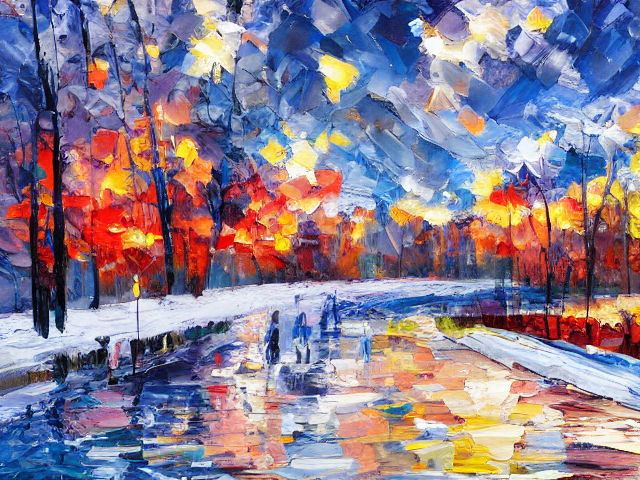

In [3]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(121)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt=" Palette knife painting, sunset city, winter,", # What to generate
    negative_prompt="Oversaturated, blurry, low quality,", # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=2,          # How strongly to follow the prompt
    num_inference_steps=40,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image:
pipe_output.images[0]

**Exercise:** 使用不同的参数，不同的prompt生成不同的图像。使用不一样的随机种子，或者去掉 `generator` 以得到随机的随机数.

Key arguments to tweak:
- 为了**VAE**能够工作，长宽必须能被8整除(后面会讲).
- noise 的 timestep数量影响生成质量. The default (50) works well, but in some cases you can get away with as few as 20 steps which is handy for experimentation.
- 为了使画面更可控，我们使用了negative prompt，你可以留空，但是很多人实践表明，这一项可以有效去除不想要东西.
- `guidance_scale`参数决定了classifier-free guidance (CFG) 的强度。[回忆Unit2中写的loss](./diffusion_and_hf_unit2_1.ipynb)。 调高以获得更符合prompt的图像，但是过高反而会导致图像不好看，可以参考下一个cell的例子。 

这里有魔法书咒语集合 [Stable Diffusion Prompt Book](https://stability.ai/sdv2-prompt-book) .

你可以在下面的单元格中看到增加CFG的效果：

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

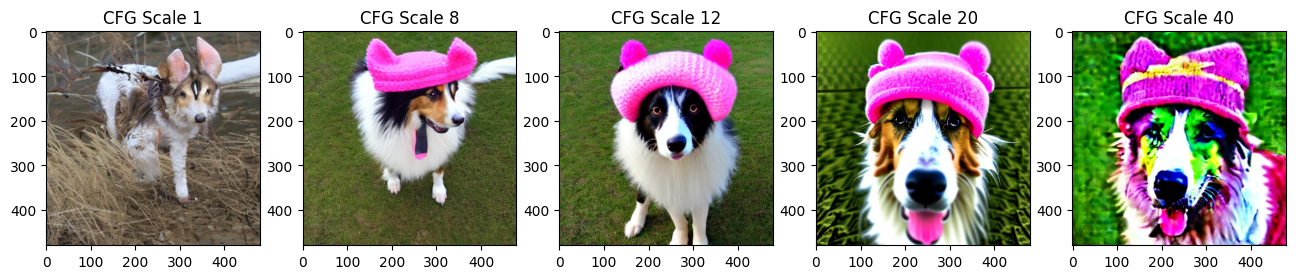

In [76]:
cfg_scales = [1, 8, 12, 20, 40] #@param
prompt = "A collie with a pink hat" #@param
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

尽量调整以生成各种各样的图案，感觉15以上，5以下都不太行

## 管线组成 Pipeline Components

我们使用的`StableDiffusionPipeline`比我们在前面几个单元中探讨过的`DDPMPipeline`要复杂一些。除了unet和调度器之外，管道中还包括一些其他的组件：

In [5]:
print(list(pipe.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor']


为了更好地理解Pipeline的工作方式，让我们简单地看看每个组件是如何运作的，然后再把它们放在一起。

### The VAE
![vae_diagram.png](./JupyterImage/theVAE.png)

VAE是什么应该不用多讲，但在这里的用处是什么呢？

从图上看，用处是两方面的
- 给输入图像降维encode
- 给unet输出的“一锅烩”（i.e. 'latent'）做decode得到最终的图像

The VAE (variational autoencoder) is a type of model that can encode its input into a compressed representation and then decode this 'latent' representation back into something close to the original input. When generating images with stable diffusion, we first **generate the latents** by applying the diffusion process in the 'latent space' of the VAE, and then **decode them at the end** to view the resulting image.

下面的 code 展示了vae的工作流程——先降维再升维


In [6]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean # PS：The code example includes the scaling factor of 0.18215 required to match the processing used during SD's training. 
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


做这一步的好处也显而易见：
- 相比 3x512x512, 4x64x64 的隐空间更小， 但是由于缩小了8倍，原始长宽必须是8的倍数
- 更小的隐空间使模型可以更高效的修改图片中的元素，而且速度更快。The VAE decoding process is not perfect, but it is good enough that the small quality tradeoff is generally worth it.

PS：在代码中有一个针对latent的缩放参数，这是为了满足SD training中的一些设定。The code example above includes the scaling factor of 0.18215 required to match the processing used during SD's training. 

### The Tokenizer and Text Encoder

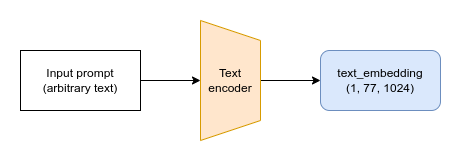

文本编码器的目标是将一个输入字符串（prompt）变成一个可以作为条件输入到UNet的vector。首先，使用管道的标记器将文本变成一系列的token（一般来说每一个词会对应一个数字，这个数字便是token）。文本编码器有一个大约5万个标记的词汇表--任何不在这个词汇表中的词都被分割成更小的子词。然后，这些标记被送入文本编码器模型本身--一个最初被训练为CLIP的文本编码器的转化器模型。希望这个预训练的转化器模型已经学会了丰富的文本表征，对扩散任务也很有用。

让我们通过对一个示例提示进行编码来测试这个过程，首先手动标记并将其送入文本编码器，然后使用管道`_encode_prompt`方法来显示整个过程，包括将长度填充/截断到最大长度77个标记：

In [94]:
# Tokenizing and encoding an example prompt manualy:

# Tokenize
input_ids = pipe.tokenizer(["A painting of a fluffyball"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
print('input_ids:', input_ids)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

# Get the final text embeddings using the pipeline's _encode_prompt function:
text_embeddings = pipe._encode_prompt("A painting of a fluffyball", device, 1, False, '')
print(text_embeddings.shape)
# print(text_embeddings)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
40346 -> fluffy
1069 -> ball
49407 -> <|endoftext|>
input_ids: tensor([[49406,   320,  3086,   539,   320, 40346,  1069, 49407]],
       device='cuda:1')
Text embeddings shape: torch.Size([1, 8, 768])
torch.Size([1, 77, 768])


可以看到，tokenizer把一句话拆成了多个token，没见过的词被拆成了更小的token，每一个token，包括开始和结束都被数据化。一个句子组成的向量(size=[1, num_words, 1])被map成[1,num_words,768]的tensor，最后补全为77个词向量。

这些text embedding（the so-called 'hidden states' of the last transformer block in the text encoder model）将作为额外参数被送入UNet，我们将在下一节看到。


### The UNet

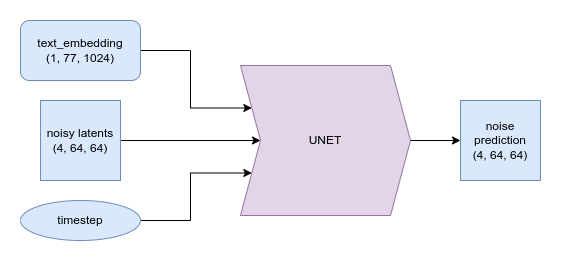

The UNet 使用从带噪声的图片上预测噪声，正如我们之前Unit看到的。在这里的不同点在于，我们放弃直接使用图片，转为使用原图片的latents作为input。
Unet 的输入包括三部分：
- 原图片经过VAE处理的latents
- 经过text encoder处理的text embedding
- timestep 

在这里我们使用假数据做一个例子：

In [8]:
# Dummy inputs:
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 768).to(device)

# Model prediction:
with torch.no_grad():
  unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape) # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


### The Scheduler 调度器

调度器存储noise schedule， 并基于模型预测更新 noisy sample. 默认的 scheduler 是 `PNDMScheduler`, 也可以换成别的相同设置的scheduler (such as `LMSDiscreteScheduler`) 。

画出 noise schedule 随着timestep规定的噪声强度 (based on $\bar{\alpha}$) :

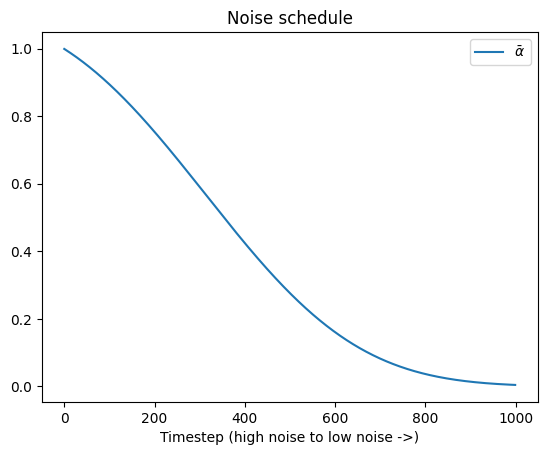

In [9]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

换一个新的scheduler看看。。。

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.16.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "trained_betas": null
}



  0%|          | 0/50 [00:00<?, ?it/s]

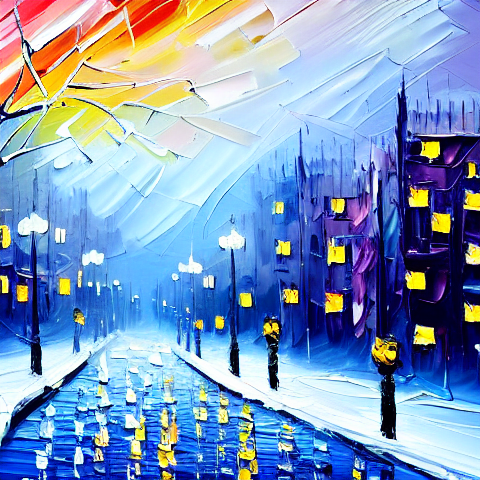

In [13]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an winter cityscape", height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(556)).images[0]


You can read more on using different schedulers [here](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion_2#how-to-load-and-use-different-schedulers).


### A DIY Sampling Loop

Now that we've seen all these components in action, we can put them together to replicate the functionality of the pipeline:

0it [00:00, ?it/s]

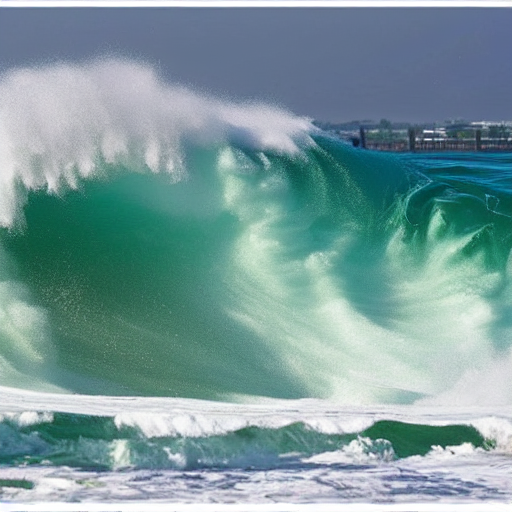

In [24]:
from tqdm.auto import tqdm

guidance_scale = 8 
num_inference_steps= 30 
prompt = "Beautiful photograph of a wave breaking" 
negative_prompt = "zoomed in, blurry, oversaturated, warped" 

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)# size = [2,77,768], ‘2’是正面和反面prompt concat在一起了

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)# 这里只要从random latent出发就好啦
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device) # 和U2一致

# Loop through the sampling timesteps （main loop）
for i, t in tqdm(enumerate(pipe.scheduler.timesteps)):
    # expand the latents if we are doing classifier free guidance # 这为了分别计算图片的noise pred的loss 和文字的noise pred的loss
    latent_model_input = torch.cat([latents] * 2)
    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    # predict the noise residual with the unet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond) # noise_pred_uncond, noise_pred_text 这两项是越来越靠近的
    # compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
  image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

结合sampling loop，我们可以更容易地理解stable diffusion。
- Todo：这个要看！ If you'd like to see this code and all the different components explored and modified in depth, check out the 'Stable Diffusion Deep Dive' [notebook](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb) and [video](https://m.youtube.com/watch?v=0_BBRNYInx8) for a more thorough exploration.

## Img2Img

In the examples so far we've generated images completely from scratch by starting from random latents and applying the full diffusion sampling loop. But we don't have to start from scratch. The Img2Img pipeline first encodes an existing image into a set of latents, then adds some noise to the latents and uses that as the starting point. The amount of noise added and the number of denoising steps applied determine the 'strength' of the img2img process. Adding just a small amount of noise (low strength) will result in very little change, while adding the maximum amount of noise and running the full denoising process will give an image that hardly resembles the input apart from some similarities on overall structure. 

This pipeline requires no special models, and so as long as the model ID is the same as our text-to-image example above no new files will need to be downloaded.

在迄今为止的例子中，我们通过从随机潜标开始，应用完整的扩散采样循环，完全从零开始生成图像。但我们不需要从头开始。Img2Img管道首先将现有图像编码为一组潜像，然后向潜像添加一些噪声，并将其作为起点。添加的噪声量和应用的去噪步骤的数量决定了Img2img过程的 "强度"。仅仅添加少量的噪声（低强度）将导致很小的变化，而添加最大数量的噪声并运行完整的去噪过程将得到一个除了在整体结构上有一些相似之处之外几乎与输入的图像不相似的图像。

这个管道不需要特殊的模型，因此只要模型的ID与我们上面的文本到图像的例子相同，就不需要下载新的文件。

In [25]:
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained("/workspace/data2/huggingface-models/stable-diffusion-v1-4/").to(device)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/28 [00:00<?, ?it/s]

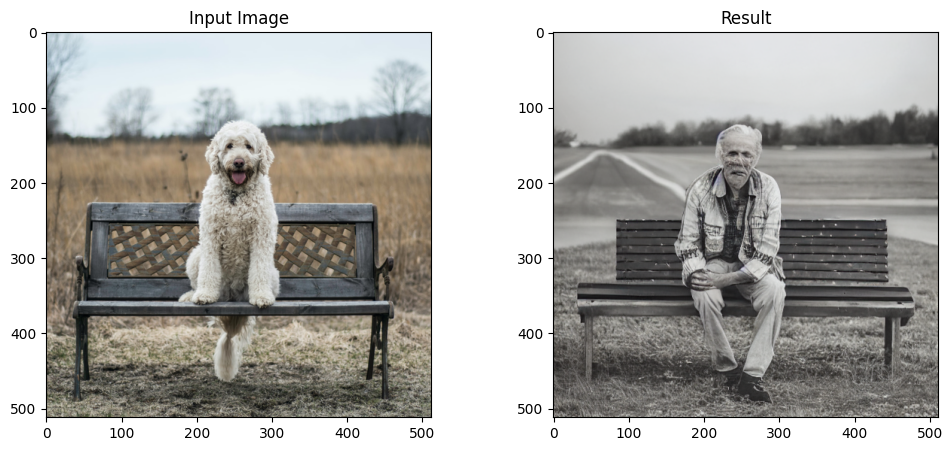

In [50]:
# 其实就是用VAE处理了想要编辑的图片，没事的时候可以尝试写loop而不是直接用pipe
# img2img_pipe.scheduler.set_timesteps(50)
# Apply Img2Img
result_image = img2img_pipe(
    prompt="A photo of a man on a bench",
    image = init_image, # The starting image
    strength = 0.7, # 0 for no change, 1.0 for max strength
    num_inference_steps=40, #step数会直接被strength影响
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

## In-Painting

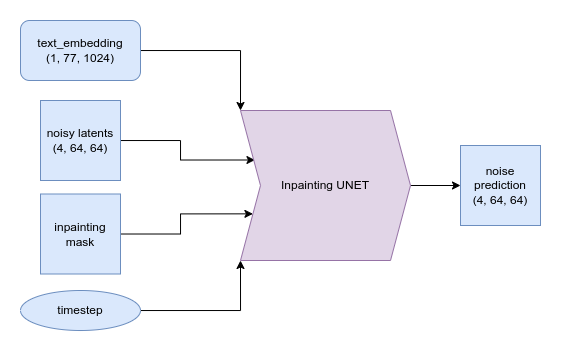

如果我们想保持输入图像的某些部分不变，但在其他部分生成新的东西，那该怎么办？这就是所谓的'inpainting'. 它也可以用相同的模型实现 demos (via the `StableDiffusionInpaintPipelineLegacy`) 我们可以通过使用一个自定义的微调版本的 "Stable Diffusion "来获得更好的结果，该版本使用一个遮罩作为附加条件。遮罩图像应该与输入图像的形状相同，在需要替换的区域为白色，在需要保持不变的区域为黑色。下面是我们如何加载这样一个管道，并将其应用于 "设置 "部分中加载的示例图像和遮罩：

In [53]:
# pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")
# 下面这个不大准，但也不是不能用，直接用硬mask降维到latent上做的
pipe = StableDiffusionInpaintPipelineLegacy.from_pretrained("/workspace/data2/huggingface-models/stable-diffusion-v1-4/").to(device)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/40 [00:00<?, ?it/s]

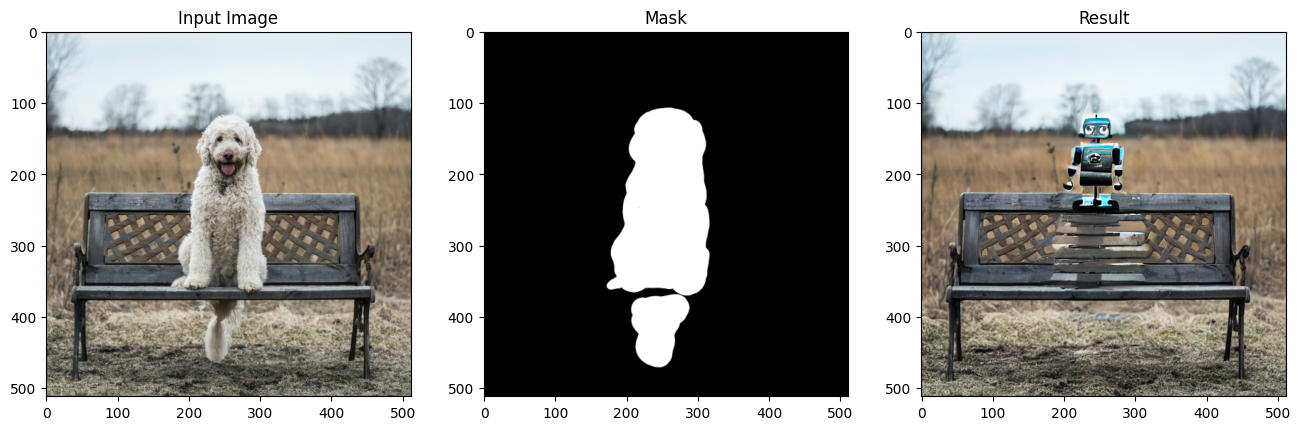

In [54]:
# Inpaint with a prompt for what we want the result to look like
prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(mask_image);axs[1].set_title('Mask')
axs[2].imshow(image);axs[2].set_title('Result');

This can be especially powerful when combined with another model to automatically generate masks. For example, [this demo space](https://huggingface.co/spaces/nielsr/text-based-inpainting) uses a model called CLIPSeg to mask out an object to be replaced based on a text description.

## Depth2Image

Img2Img很好，但有时我们想创建一个新的图像，其构图与原图相同，但颜色或纹理完全不同。要找到一个Img2Img的强度，保留我们想要的布局，同时又能保持输入的颜色，是很困难的。

是时候建立另一个微调模型了!这个模型在生成时将深度信息作为附加条件。该管道使用深度估计模型来创建深度图，然后在生成图像时将其送入微调的UNet，以（希望）保留初始图像的深度和结构，同时填入全新的内容。

打开思路！既然mask可以作为congdition输入，那别的东西呢，这里有一个先为图片估计深度图然后作为一个condition输入的例子。
首先载入finetune过的模型

In [ ]:
# Load the Depth2Img pipeline (requires a suitable model)
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth")
pipe = pipe.to(device)

In [ ]:
# Inpaint with a prompt for what we want the result to look like
prompt = "An oil painting of a man on a bench"
image = pipe(prompt=prompt, image=init_image).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(image);axs[1].set_title('Result');

请注意输出结果与img2img的例子相比如何--这里有更多的颜色变化，但整体结构仍然忠实于原作。在这种情况下，这并不理想，因为这个人被赋予了一些极其怪异的解剖结构来匹配狗的形状，但在某些情况下，这是非常有用的。关于这种方法的 "杀手级应用 "的例子，请看这条[推文](https://twitter.com/CarsonKatri/status/1600248599254007810?s=20&t=BlzSK26sfqi2336SN0gKpQ) 它显示了深度模型被用来为一个三维场景贴图！

# Where Next?

Hopefully this has given you a taste for the many this that Stable Diffusion can do! Once you get tired of playing with the examples in this notebook, check out the **DreamBooth hackathon** notebook to see how to fine-tune your own version of Stable Diffusion which can be used with the text-to-image or img2img pipelines we've seen here.

If you're curious to dig deeper into how the different components work, then check out the **Stable Diffusion Deep Dive** notebook which goes into much more detail and shows some additional tricks we can do.

 'Stable Diffusion Deep Dive' [notebook](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb) and [video](https://m.youtube.com/watch?v=0_BBRNYInx8)

Be sure to share your creations with us and the community! 